# Different high voltage settings

- COMSOL files in/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/02.sweeps.target_pos.010.mph

- extraction voltage is -3 kV, extraction distance offset is 10 mm

- HV are -60, -80, -100, -120, -140 kV

- 1 mA ion beam current

- datafiles are in /Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData


| run | distance centerline target to ion source aperture  |   
|---|---|
| 010  | 90 cm  | 
| 011  | 100 cm  |   
| 012  | 120 cm  |  

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


folder = '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/'
outfolder = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/'
main_figname= 'FWHM_vs_x'
files = os.listdir(folder)

# what are the sweep values
sweep_vals = ['60', '80', '100', '120', '140']

fignames = [f.replace('.csv', '') for f in files]
datafiles = [f"{folder}{f}" for f in files]

files

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/'

In [ ]:
for ii in range(0, len(files)):
    fname = datafiles[ii]
    dic_dfs = preprocess_COMSOL_sweep(fname, sweep_vals)
    for key in dic_dfs:
        data = dic_dfs[key]
        figname = f"{files[ii]}_{key}"
        make_plot_KDE(data, outfolder, figname)

## Function to process the COMSOL output (column headers with commas are a problem)

In [12]:
def preprocess_COMSOL_sweep(fname, sweep_vals):
    """
    fname: csv file of COMSOL output to read
    sweep_vals: what are the sweep values in a list
    
    Returns a dictionary with the dataframes qx qy qz for each file
    """
    
    # read the data and format the , correctly
    data = pd.read_csv(fname, skiprows=7, index_col=0, nrows=10)
    col_str = ''.join(data.columns.tolist())
    col_str = col_str.replace('q', ' ,q')
    col_list = col_str.split(',')
    col_list = col_list[1:]


    # read the data again, use the columns found before as the headers
    data = pd.read_csv(fname, skiprows=8, index_col=0, header=None)
    data.columns = col_list

    # filter the columns
    d_sweep = {}
    # dictionary of the dataframes, each dataframe is a separate sweep value
    dic_dfs = {}
    for val in sweep_vals:
        cols = [c for c in data.columns if val in c]
        d_sweep[val] = cols

    # add each dataframe to a separate place in the dictionary
    for key in d_sweep.keys():
        this_data = data.loc[:,d_sweep[key]]
        # rename the columns in qx, qy, qz
        new_cols = []
        for c in cols:
            if 'qx' in c:
                new_cols.append('qx')
            if 'qy' in c:
                new_cols.append('qy')
            if 'qz' in c:
                new_cols.append('qz')
        this_data.columns = new_cols
        dic_dfs[key] = this_data
        
    return dic_dfs

## Function to make the KDE plot

In [13]:
def make_plot_KDE(data, outfolder, figname):
    """
    Makes the gaussian kde and the y z plot.
    data is the dataframe with qx, qy, qz as headers and reach row is one sample data with the respecitve positions
    """
    nbins = 200
    lim = 4
    #     print(data[pd.isnull(data).any(axis=1)])
    data.to_csv(f"{outfolder}/{figname}.csv")
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#     print(zi.reshape(xi.shape))
    # plot
    fs = 20

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-lim,lim+1,1))
    plt.xticks(np.arange(-lim,lim+1,1))


    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40])
#     print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
    plt.savefig(f'{outfolder}/{figname}.pdf')

    plt.show()

    # query from the estimated pdf
    qry_eval = np.linspace(-lim,lim,100)
    eval_x = [k.evaluate([x,0])[0] for x in qry_eval] # for z = 0 in the upper plot
    eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot

    # fit FWHM
    def gauss(x, a, x0, sigma):
        return a * np.exp(-(x-x0)**2/(2*sigma**2))


    p0 = [1, 1, 1] # Initial guess for the parameters
    # fit for parallel to x axis
    X = qry_eval
    Y = eval_x
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_x, x0_x, sigma_x = popt
    Y_fit_x = gauss(X, *popt)
    FWHM_x = 2 * sigma_x * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in x: {FWHM_x}')

    # fit for parallel to y axis
    X = qry_eval
    Y = eval_y
    popt, pcov = curve_fit(gauss, X, Y, p0, maxfev=30000)
    A_y, x0_y, sigma_y = popt
    FWHM_y = 2 * sigma_y * np.sqrt(2 * np.log(2))  # FWHM
    print(f'FWHM in y: {FWHM_y}')
    Y_fit_y = gauss(X, *popt)
#     print(gauss(x0_y, *popt), A_y)

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, 0.30)
    # top plot
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
    plt.plot(qry_eval, Y_fit_x, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_x/2,FWHM_x/2],[A_x/2,A_x/2], '--', color='black')
    plt.text(-0.7, .06, f'FWHM = {FWHM_x:.2f} mm', fontsize=14)
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.4,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    plt.ylim(ylims)
    # bottom plot
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
    plt.plot(qry_eval, Y_fit_y, color='darkred',linewidth=2.0, label='Gaussian fit')
    plt.plot([-FWHM_y/2+x0_y,FWHM_y/2+x0_y],[gauss(-FWHM_y/2+x0_y,*popt),gauss(FWHM_y/2+x0_y,*popt)], '--', color='black')
    plt.text(-0.3, .06, f'FWHM = {FWHM_y:.2f} mm', fontsize=14)
    
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.4,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.savefig(f'{outfolder}/{figname}_YZ.pdf')
    plt.show()

# Get spot size for different distances and high voltages

In [11]:
def get_FWHM(x, k, r, ax):
    """
    Get the FWHMs parallel to the axis: ax
    """
    assert ax in ['x', 'y']
    if ax == 'x':
        y = [k.evaluate([y,r])[0] for y in x]
    else:
        y = [k.evaluate([r,y])[0] for y in x]
    
    if np.max(y) > 1e-4:
        def find_nearest(array, value):

            array = np.asarray(array)
            dis = (np.abs(array - value))
#             if len(dis) < 5:
#                 print(y, array, value)
            idx = dis.argmin()

            return idx, array[idx]

        Y_max = np.max(y)
        Y_max_half = Y_max/2.0
    #     print(Y_max, Y_max_half)
        # x point on positive and side
        idx_0 = find_nearest(x, Y_max)[0]
        idx_pos_max_half = find_nearest(y[idx_0:], Y_max_half)[0]
        idx_neg_max_half = find_nearest(y[:idx_0], Y_max_half)[0]
    #     print(find_nearest(eval_x[idx_0:], Y_max_half))
        # FWHM
        FWHM = x[idx_pos_max_half+idx_0]-x[idx_neg_max_half]

    #     return x[idx_neg_max_half], x[idx_pos_max_half+idx_0], FWHM
        return FWHM
    else:
        return 0

def get_max_FWHMs(data, nbins=400, eval_points=300, lim=4):
    """
    returns the maximum values for the FWHM paralell to x and y direction. X is corresponding to parallel to y, z is parallel to y
    """
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))

    eval_points 
    qry_eval = np.linspace(-lim,lim,eval_points)

    df = pd.DataFrame({'qry_eval': qry_eval})
    df['FWHM_z'] = df['qry_eval'].apply(lambda r: get_FWHM(qry_eval, k, r, ax='y'))
    df['FWHM_y'] = df['qry_eval'].apply(lambda r: get_FWHM(qry_eval, k, r, ax='x'))
    FWHM_y = np.max(df['FWHM_y'] )
    FWHM_z = np.max(df['FWHM_z'] )
    
    return pd.Series([FWHM_y, FWHM_z], index=['FWHM_y', 'FWHM_z'])

In [17]:
d_FWHM = {}
for ii in range(0, len(files)):
    fname = datafiles[ii]
    dic_dfs = preprocess_COMSOL_sweep(fname, sweep_vals)
    df = pd.DataFrame()


    for key in dic_dfs:
        print(fname, key)
        data = dic_dfs[key]
        s = get_max_FWHMs(data, nbins=400, eval_points=300, lim=4)
        df[f"{key}"] = s
    df = df.T
    d_FWHM[files[ii]] = df
    df.to_csv(f"{outfolder}/FWHM_data_{files[ii]}_{key}.csv")
    

d_FWHM

/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/012.csv 60
/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/012.csv 80
/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/012.csv 100
/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/012.csv 120
/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/012.csv 140
/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/011.csv 60
/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sweeps.target_pos/2020-02-10.more_HV/particleData/011.csv 80
/Users/hkromer/02_PhD/02_Data/01_COMSOL/01_IonOptics/03.new_chamber/02.sw

{'012.csv':        FWHM_y    FWHM_z
 60   2.943144  5.591973
 80   2.541806  4.949833
 100  2.247492  4.494983
 120  2.033445  4.093645
 140  1.819398  3.799331,
 '011.csv':        FWHM_y    FWHM_z
 60   2.916388  5.110368
 80   2.488294  4.468227
 100  2.193980  3.986622
 120  1.953177  3.638796
 140  1.765886  3.317726,
 '010.csv':        FWHM_y    FWHM_z
 60   2.782609  4.468227
 80   2.381271  3.879599
 100  2.060201  3.424749
 120  1.792642  3.103679
 140  1.632107  2.836120}

# Read from file

In [61]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from scipy.stats import kde
from scipy import optimize

from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
d_FWHM = {}
fname = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/FWHM_data_010.csv_140.csv'
df = pd.read_csv(fname, index_col=0)
d_FWHM['010.csv'] = df

fname = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/FWHM_data_011.csv_140.csv'
df = pd.read_csv(fname, index_col=0)
d_FWHM['011.csv'] = df

fname = '/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/FWHM_data_012.csv_140.csv'
df = pd.read_csv(fname, index_col=0)
d_FWHM['012.csv'] = df

In [214]:
files = os.listdir('/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/')
files = [f for f in files if f.endswith('.csv')]
files = [f for f in files if 'FWHM' not in f]
files = [f for f in files if 'data' not in f]
# 010: 90 cm distance
# 011: 100 cm distance
# 012: 120 cm distance

files


['010.csv_140.csv',
 '012.csv_80.csv',
 '011.csv_60.csv',
 '011.csv_100.csv',
 '012.csv_100.csv',
 '010.csv_80.csv',
 '010.csv_120.csv',
 '010.csv_60.csv',
 '010.csv_100.csv',
 '012.csv_120.csv',
 '011.csv_140.csv',
 '012.csv_140.csv',
 '012.csv_60.csv',
 '011.csv_120.csv',
 '011.csv_80.csv']

## Optimization to fit tophat

In [137]:
from scipy import optimize as opt

# def model(x, *p):
#     """
#     top hat function with four parameters that are:
#     # first parameter: base_level
#     # second parameter: hat_level
#     # third parameter: hat_mid
#     # forth parameter: hat_width
#     """
#     base_level, hat_level, hat_mid, hat_width = p

#     return np.where((hat_mid-hat_width/2. < x) & (x < hat_mid+hat_width/2.), hat_level, base_level)

# def model(x, *p):
#     """
#     top hat function with three parameters that are:
#     # first parameter: hat_level
#     # second parameter: hat_mid
#     # third parameter: hat_width
#     """
#     hat_level, hat_mid, hat_width = p
#     base_level = 0

#     return np.where((hat_mid-hat_width/2. < x) & (x < hat_mid+hat_width/2.), hat_level, base_level)
# def initial_guess(x, y):
#     """
#     For each of the parameters from the top hat fit function, make a guess for the value from a Normal distribution.
#     Returns the guessed parameters
#     """
#     params = []
    
# #     # first parameter: base_level
# #     params.append(np.random.normal(loc=np.min(y), scale=np.std(y)))   
#     # second parameter: hat_level
#     params.append(np.random.normal(loc=np.max(y), scale=np.std(y)))   
# #     params.append(np.max(y))   
#     # third parameter: hat_mid
#     params.append(np.random.normal(loc=0, scale=np.std(y)))   
#     # forth parameter: hat_width
#     params.append(np.random.normal(loc=np.std(x), scale=np.std(x)))   
    
    
#     return np.asarray(params)

def model(x, *p):
    """
    top hat function with three parameters that are:
    # first parameter: hat_level
    # second parameter: hat_right
    # third parameter: hat_left
    """
    hat_level, hat_right, hat_left = p
    base_level = 0

    return np.where((hat_left < x) & (x < hat_right), hat_level, base_level)

def initial_guess(x, y):
    """
    For each of the parameters from the top hat fit function, make a guess for the value from a Normal distribution.
    Returns the guessed parameters
    """
    params = []
    
    # first parameter: hat_level
    params.append(np.random.normal(loc=np.max(y), scale=np.std(y)))   
    # second parameter: hat_right
    params.append(np.random.normal(loc=np.std(x)/2, scale=np.std(y)))   
    # third parameter: hat_left
    params.append(np.random.normal(loc=-np.std(x)/2, scale=np.std(x)))   
    
    
    return np.asarray(params)

def loss_function(p, x_data, y_data, model):
    """
    Loss function is the total sum of squared differences between the data points (given as x_data, y_data and the predicted points.
    - p: model parameters
    - x_data, y_data: data points
    - model: function for the model (fit)
    """
    # predicted points
    y_pred = model(x_data, *p)

    loss = np.sum( (y_pred - y_data)**2 ) # total sum of squared differences

    return loss

def train(model, x_train, y_train, n_iter=3):
    p_best = None
    best_loss = 1e100
    for _ in range(n_iter):
        # The arguments that will get passed to the error function,
        # in addition to the model parameters of the current iteration.
        loss_fun_args = (x_train, y_train, model)
        p_initial = initial_guess(x=x_train, y=y_train)
        # Confusingly the `x0` argument is not expecting the x value of
        # the data points or for the 0th element of a list. It is for the
        # initial guess for the parameter values.
        res = opt.minimize(
            fun=loss_function,
            x0=p_initial,
            method="Nelder-Mead",
            args=loss_fun_args,
        )
        loss = loss_function(
            res.x,
            x_train,
            y_train,
            model,
        )
        if loss < best_loss:
            best_loss = loss
            p_best = res.x

    return p_best



def compare_models(x, y, n_iter=3):
    training_errors = []
    testing_errors = []
    
    x_train, y_train, x_test, y_test = x, y, x, y

    p_final = train(model, x_train, y_train)

    training_errors.append(loss_function(
            p_final, x_train, y_train, model))
    testing_errors.append(loss_function(
            p_final, x_test, y_test, model))


    return p_final, training_errors, testing_errors


def get_pdf_along_ax(data, nbins=400, eval_points=300, lim=4):
    """
    Takes the qx, qy, qz dataset and computes the pdf using a gaussian kernel density estimator. Then there is a slice along y and z which will be returned.
    - data: qx, qy, qz dataset as a dataframe from COMSOL
    - nbins: Number of bins to interpolate for the kde between -lim and lim
    - eval_points: how many evaluation points for the pdf along an axis
    - lim: extension of the gaussian kernel estimator 
    """
    
    Y = data['qy'].values # Y axis
    Z = data['qz'].values # Z axis
    my_data = np.vstack([Y, Z])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    
    qry_eval = np.linspace(-lim,lim,eval_points)

    eval_Y = [k.evaluate([x,0])[0] for x in qry_eval] 
    eval_Z = [k.evaluate([0,y])[0] for y in qry_eval] 
    
    return qry_eval, eval_Y, eval_Z

def plot_pdf(qry_eval, eval_Y, eval_Z, Y_vals, Z_vals):
    """
    takes the qry values and plots them for each axis
    """
    # Y axis
    p = Y_vals[0]
    Y = model(qry_eval, *p)
    plt.plot(qry_eval, Y, label='Y tophat', color='darkblue', ls='--')
    plt.plot(qry_eval, eval_Y, label='Y KDE', color='darkblue', alpha=0.75)
    plt.legend()
    plt.show()
    
    # Z axis
    p = Z_vals[0]
    Z = model(qry_eval, *p)
    plt.plot(qry_eval, Z, label='Z tophat', color='darkred', ls='--')
    plt.plot(qry_eval, eval_Z, label='Z KDE', color='darkred', alpha=0.75)
    
    plt.legend()
    plt.show()
    
    
def main(data, nbins=400, eval_points=300, lim=4, n_iter=3, plot=False, verbose=False):
    """
    Main function handler
    """
    qry_eval, eval_Y, eval_Z = get_pdf_along_ax(data, nbins, eval_points, lim)

    # model fit along Y
    Y_vals = compare_models(qry_eval, eval_Y, n_iter) # p_final, training_errors, testing_errors
    Z_vals = compare_models(qry_eval, eval_Z, n_iter) # p_final, training_errors, testing_errors
    
    if plot: plot_pdf(qry_eval, eval_Y, eval_Z, Y_vals, Z_vals)
    if verbose: print(Y_vals, Z_vals)
    return Y_vals, Z_vals

### Show the hat function

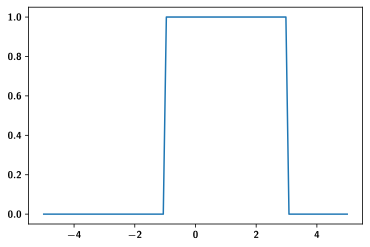

In [138]:

X = np.linspace(-5,5, 100)
# base_level = -1
hat_level, hat_right, hat_left = 1, 3, -1
Y = model(X, hat_level, hat_right, hat_left)
plt.plot(X, Y)
plt.show()



Doing 90 cm, 140 kV


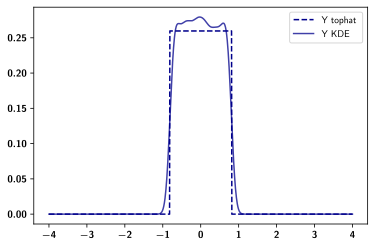

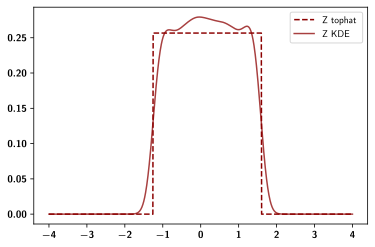

(array([ 0.25968126,  0.81625001, -0.81369888]), [0.3627221758701237], [0.3627221758701237]) (array([ 0.25659276,  1.60195459, -1.25791521]), [0.6485517758455198], [0.6485517758455198])




Doing 120 cm, 80 kV


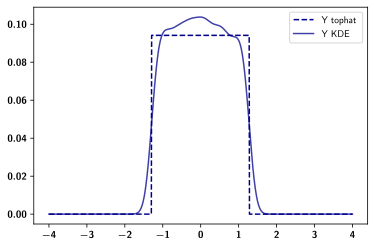

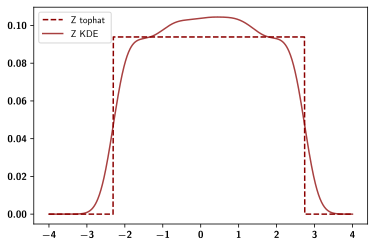

(array([ 0.09414018,  1.28216809, -1.296886  ]), [0.08526461165559335], [0.08526461165559335]) (array([ 0.09389677,  2.73703902, -2.30622374]), [0.17671583395984858], [0.17671583395984858])




Doing 100 cm, 60 kV


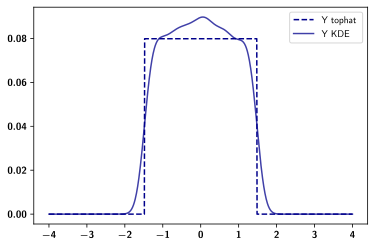

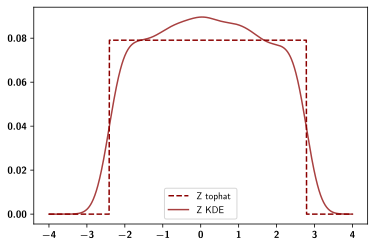

(array([ 0.07986384,  1.48410568, -1.48138102]), [0.07425027651964317], [0.07425027651964317]) (array([ 0.07909273,  2.78375912, -2.40883355]), [0.13285071928373537], [0.13285071928373537])




Doing 100 cm, 100 kV


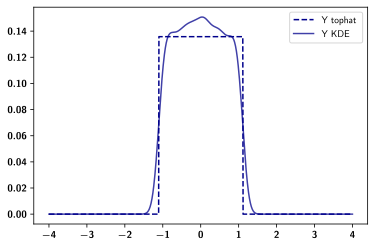

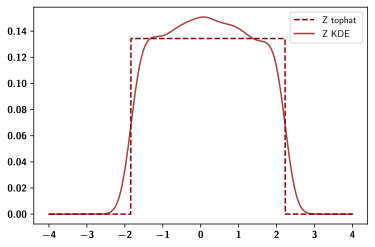

(array([ 0.13576908,  1.11116119, -1.10516383]), [0.15236097760589937], [0.15236097760589937]) (array([ 0.13434831,  2.22759111, -1.84384452]), [0.28311698854727085], [0.28311698854727085])




Doing 120 cm, 100 kV


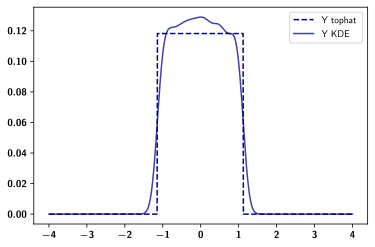

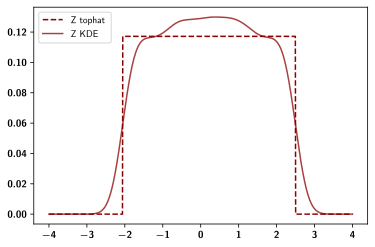

(array([ 0.1181815,  1.1217361, -1.1466501]), [0.11485623874687653], [0.11485623874687653]) (array([ 0.11716742,  2.49706125, -2.05912021]), [0.24371056447471545], [0.24371056447471545])




Doing 90 cm, 80 kV


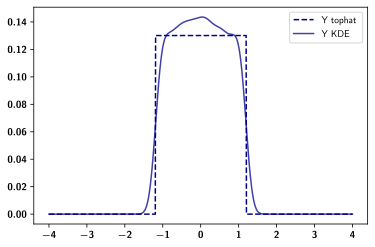

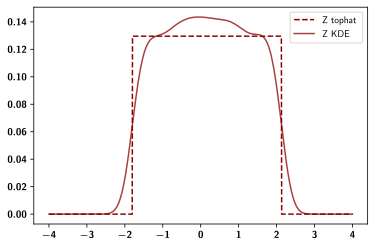

(array([ 0.13010884,  1.20190088, -1.19365191]), [0.15062392879876407], [0.15062392879876407]) (array([ 0.12954654,  2.13100249, -1.80310571]), [0.2589575159403854], [0.2589575159403854])




Doing 90 cm, 120 kV


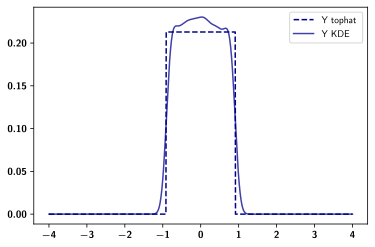

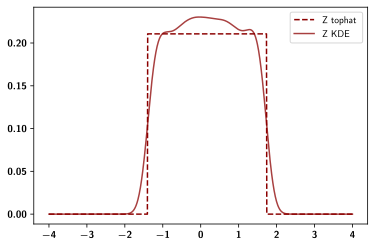

(array([ 0.21292981,  0.91206142, -0.91204772]), [0.28385614916440133], [0.28385614916440133]) (array([ 0.21065314,  1.73640874, -1.40177551]), [0.5048401314903985], [0.5048401314903985])




Doing 90 cm, 60 kV


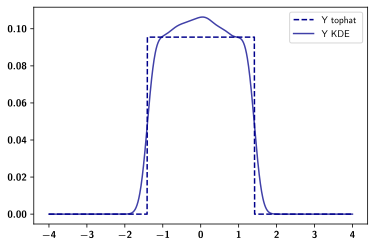

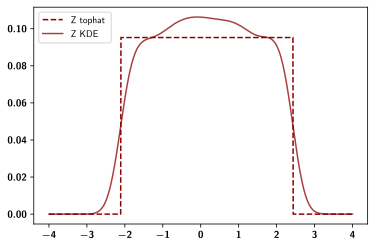

(array([ 0.09549226,  1.41533627, -1.41075534]), [0.09815324560977207], [0.09815324560977207]) (array([ 0.09525526,  2.43169915, -2.10407156]), [0.16489984299142807], [0.16489984299142807])




Doing 90 cm, 100 kV


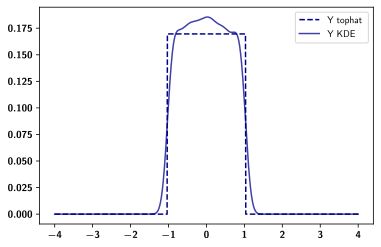

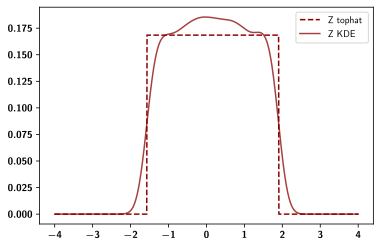

(array([ 0.16960776,  1.03165631, -1.03223377]), [0.21252697472984525], [0.21252697472984525]) (array([ 0.16847831,  1.90587996, -1.56915476]), [0.3724970814373374], [0.3724970814373374])




Doing 120 cm, 120 kV


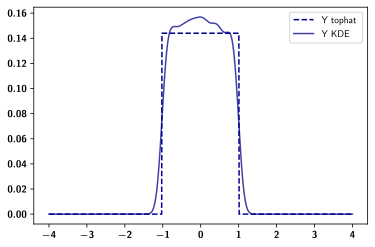

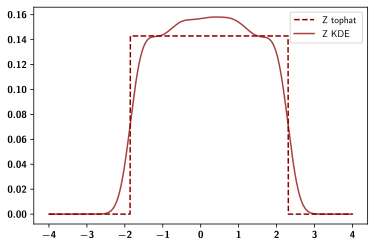

(array([ 0.14398192,  1.00957576, -1.02270317]), [0.1495467987238082], [0.1495467987238082]) (array([ 0.14293783,  2.30504439, -1.86024495]), [0.3261924104449472], [0.3261924104449472])




Doing 100 cm, 140 kV


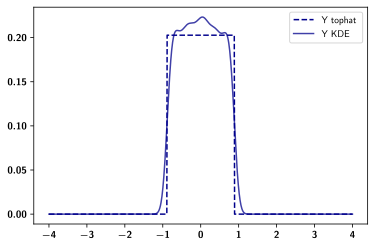

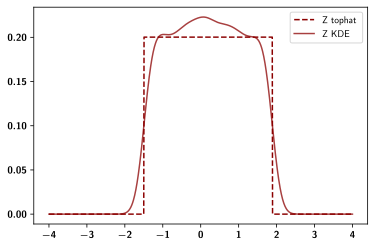

(array([ 0.20273367,  0.88947381, -0.89055775]), [0.26161836207754324], [0.26161836207754324]) (array([ 0.20022787,  1.89156456, -1.4956087 ]), [0.5030052515402217], [0.5030052515402217])




Doing 120 cm, 140 kV


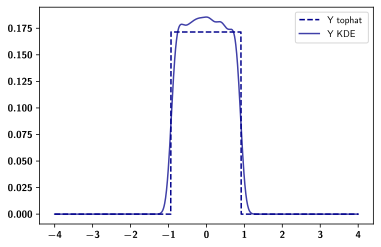

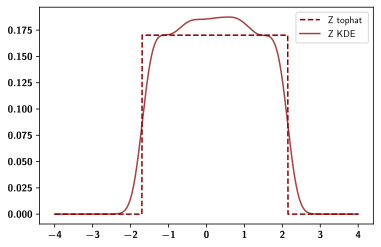

(array([ 0.17150042,  0.91014178, -0.93908718]), [0.19012133174730506], [0.19012133174730506]) (array([ 0.17023037,  2.14724248, -1.69935543]), [0.41743117344988595], [0.41743117344988595])




Doing 120 cm, 60 kV


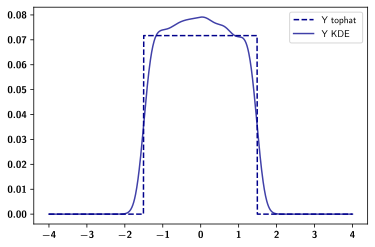

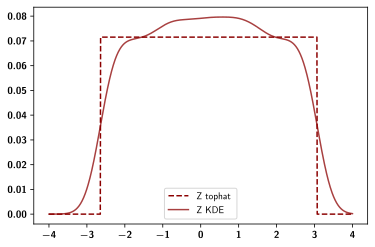

(array([ 0.07169902,  1.48981127, -1.50859713]), [0.057976142195858935], [0.057976142195858935]) (array([ 0.07152679,  3.06793944, -2.64305524]), [0.11730995636411354], [0.11730995636411354])




Doing 100 cm, 120 kV


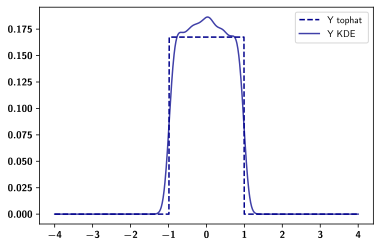

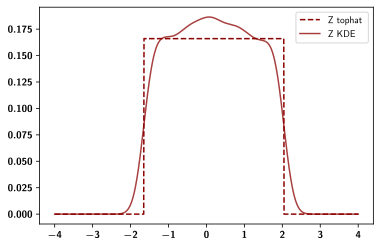

(array([ 0.16743843,  0.99001508, -0.98293019]), [0.20607870318434598], [0.20607870318434598]) (array([ 0.16602471,  2.0395324 , -1.64727733]), [0.3938166331076936], [0.3938166331076936])




Doing 100 cm, 80 kV


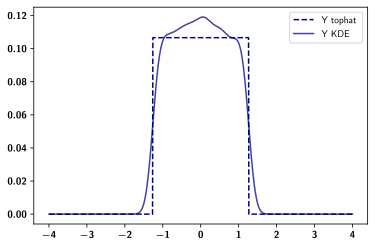

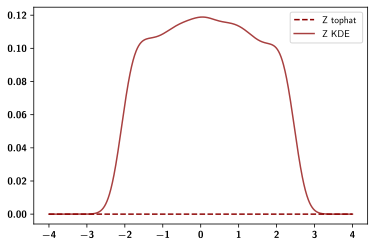

(array([ 0.10663438,  1.26802475, -1.26570518]), [0.11069644210699253], [0.11069644210699253]) (array([0.13020286, 1.07539996, 1.58747022]), [6.529608584403753], [6.529608584403753])




In [148]:
LUT_dist = {'010': '90 cm', # lookup table for distance
          '011': '100 cm', 
          '012': '120 cm'}
res = []
for f in files:
    ID = f[0:3]
    dist = LUT_dist[ID] # distance
    HV = re.findall(r'_(\d+).csv', f)[0]
    print('\n')    
    print(f'Doing {dist}, {HV} kV')
    data = pd.read_csv(f'/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/{f}', index_col=0)
    Y_vals, Z_vals = main(data, nbins=300, eval_points=1000, lim=4, n_iter=1e7, plot=True, verbose=True)
    res.append([Y_vals, Z_vals])
    print('\n')

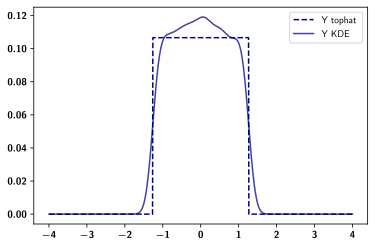

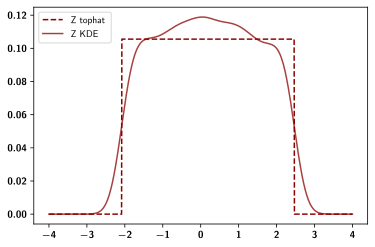

(array([ 0.10663587,  1.26516087, -1.26633017]), [0.11069644216489584], [0.11069644216489584]) (array([ 0.10554935,  2.4681173 , -2.0854417 ]), [0.2017241422755619], [0.2017241422755619])


In [164]:
f = files[-1]
data = pd.read_csv(f'/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/{f}', index_col=0)
Y_vals, Z_vals = main(data, nbins=300, eval_points=1000, lim=4, n_iter=1e7, plot=True, verbose=True)

In [206]:
tophats = []
rights_y = []
rights_z = []
lefts_y = []
lefts_z = []
tops_y = []
tops_z = []
for r in res:
    dist_y = r[0][0][1] - r[0][0][2]
    dist_z = r[1][0][1] - r[1][0][2]
    tophats.append([dist_y, dist_z])
    right_y = r[0][0][1]
    right_z = r[1][0][1]
    
    left_y = r[0][0][2]
    left_z = r[1][0][2]
    
    rights_y.append(right_y)
    rights_z.append(right_z)
    
    lefts_y.append(left_y)
    lefts_z.append(left_z)
    
    top_y = r[0][0][0]
    top_z = r[1][0][0]
    
    tops_y.append(top_y)
    tops_z.append(top_z)    

In [212]:
jj = 9
lefts_y[jj], lefts_z[jj], tops_y[jj], tops_z[jj], res[jj]

(-1.0227031688023407,
 -1.860244946675345,
 0.14398191732982868,
 0.14293782873726996,
 [(array([ 0.14398192,  1.00957576, -1.02270317]),
   [0.1495467987238082],
   [0.1495467987238082]),
  (array([ 0.14293783,  2.30504439, -1.86024495]),
   [0.3261924104449472],
   [0.3261924104449472])])

In [213]:
df_res = pd.DataFrame()
LUT_dist = {'010': '90 cm', # lookup table for distance
          '011': '100 cm', 
          '012': '120 cm'}
IDs = []
HVs = []
dists = []
for f in files:
    ID = f[0:3]
    dist = LUT_dist[ID] # distance
    HV = re.findall(r'_(\d+).csv', f)[0]
    dists.append(dist)
    HVs.append(HV)
    IDs.append(ID)
    
df_res['ID'] = IDs
df_res['HV'] = HVs
df_res['dists'] = dists
df_res['d'] = df_res['dists'].str.extract(r'(\d+) cm').astype(float) # distance in cm as float
df_res['hv'] = df_res['HV'].astype(float) # HV in kV as float

df_res['hat_right_y'] = rights_y
df_res['hat_right_z'] = rights_z

df_res['hat_left_y'] = lefts_y
df_res['hat_left_z'] = lefts_z

df_res['hat_top_y'] = tops_y
df_res['hat_top_z'] = tops_z


df_res['tophat_y'] = [t[0] for t in tophats]
df_res['tophat_z'] = [t[1] for t in tophats]

df_res = df_res.sort_values(by=['d', 'hv'])
df_res.to_csv('/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/dataframe_tophat_fit.csv', index=False)
df_res

,ID,HV,dists,d,hv,hat_right_y,hat_right_z,hat_left_y,hat_left_z,hat_top_y,hat_top_z,tophat_y,tophat_z
7,010,60,90 cm,90.0,60.0,1.415336,2.431699,-1.410755,-2.104072,0.095492,0.095255,2.826092,4.535771
5,010,80,90 cm,90.0,80.0,1.201901,2.131002,-1.193652,-1.803106,0.130109,0.129547,2.395553,3.934108
8,010,100,90 cm,90.0,100.0,1.031656,1.905880,-1.032234,-1.569155,0.169608,0.168478,2.063890,3.475035
6,010,120,90 cm,90.0,120.0,0.912061,1.736409,-0.912048,-1.401776,0.212930,0.210653,1.824109,3.138184
0,010,140,90 cm,90.0,140.0,0.816250,1.601955,-0.813699,-1.257915,0.259681,0.256593,1.629949,2.859870
2,011,60,100 cm,100.0,60.0,1.484106,2.783759,-1.481381,-2.408834,0.079864,0.079093,2.965487,5.192593
14,011,80,100 cm,100.0,80.0,1.268025,2.468117,-1.265705,-2.085442,0.106634,0.105549,2.533730,4.553559
3,011,100,100 cm,100.0,100.0,1.111161,2.227591,-1.105164,-1.843845,0.135769,0.134348,2.216325,4.071436
13,011,120,100 cm,100.0,120.0,0.990015,2.039532,-0.982930,-1.647277,0.167438,0.166025,1.972945,3.686810
10,011,140,100 cm,100.0,140.0,0.889474,1.891565,-0.890558,-1.495609,0.202734,0.200228,1.780032,3.387173


## Load from file

In [3]:
df_res = pd.read_csv('/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/dataframe_tophat_fit.csv', index_col=0)
df_res

,HV,dists,d,hv,hat_right_y,hat_right_z,hat_left_y,hat_left_z,hat_top_y,hat_top_z,tophat_y,tophat_z
ID,,,,,,,,,,,,
10,60,90 cm,90.0,60.0,1.415336,2.431699,-1.410755,-2.104072,0.095492,0.095255,2.826092,4.535771
10,80,90 cm,90.0,80.0,1.201901,2.131002,-1.193652,-1.803106,0.130109,0.129547,2.395553,3.934108
10,100,90 cm,90.0,100.0,1.031656,1.905880,-1.032234,-1.569155,0.169608,0.168478,2.063890,3.475035
10,120,90 cm,90.0,120.0,0.912061,1.736409,-0.912048,-1.401776,0.212930,0.210653,1.824109,3.138184
10,140,90 cm,90.0,140.0,0.816250,1.601955,-0.813699,-1.257915,0.259681,0.256593,1.629949,2.859870
11,60,100 cm,100.0,60.0,1.484106,2.783759,-1.481381,-2.408834,0.079864,0.079093,2.965487,5.192593
11,80,100 cm,100.0,80.0,1.268025,2.468117,-1.265705,-2.085442,0.106634,0.105549,2.533730,4.553559
11,100,100 cm,100.0,100.0,1.111161,2.227591,-1.105164,-1.843845,0.135769,0.134348,2.216325,4.071436
11,120,100 cm,100.0,120.0,0.990015,2.039532,-0.982930,-1.647277,0.167438,0.166025,1.972945,3.686810


In [4]:
df_res[df_res['d'] == 90]

,HV,dists,d,hv,hat_right_y,hat_right_z,hat_left_y,hat_left_z,hat_top_y,hat_top_z,tophat_y,tophat_z
ID,,,,,,,,,,,,
10,60,90 cm,90.0,60.0,1.415336,2.431699,-1.410755,-2.104072,0.095492,0.095255,2.826092,4.535771
10,80,90 cm,90.0,80.0,1.201901,2.131002,-1.193652,-1.803106,0.130109,0.129547,2.395553,3.934108
10,100,90 cm,90.0,100.0,1.031656,1.905880,-1.032234,-1.569155,0.169608,0.168478,2.063890,3.475035
10,120,90 cm,90.0,120.0,0.912061,1.736409,-0.912048,-1.401776,0.212930,0.210653,1.824109,3.138184
10,140,90 cm,90.0,140.0,0.816250,1.601955,-0.813699,-1.257915,0.259681,0.256593,1.629949,2.859870


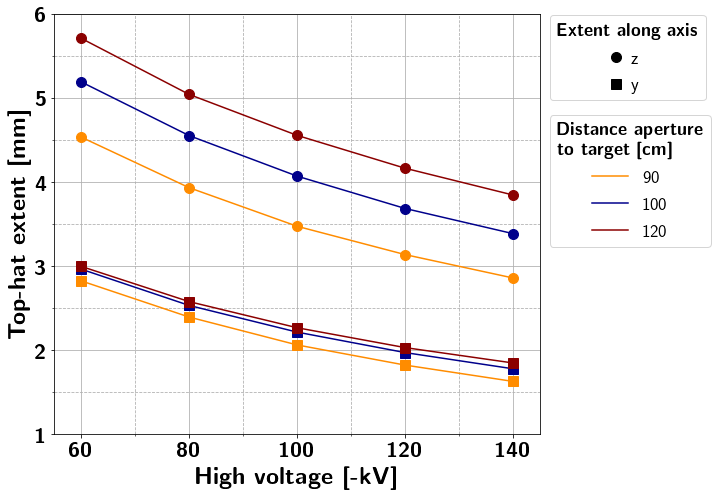

In [6]:
from matplotlib.ticker import NullFormatter
from matplotlib import pyplot, transforms
import matplotlib
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline
import os
import copy
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

# plot for each time
fig, ax1 = plt.subplots(figsize=(10, 7))
fs = 24

ls_y = '-'
ls_z = '-'
m_y = 'o'
m_z = 's'

# 010: 90 cm distance
df = df_res[df_res['d'] == 90]
x = df['hv'].astype(float).values # high voltages
c = 'darkorange' # color

y = df['tophat_z'].values
lbl = 'FWHM z 90cm'
ax1.plot(x, y, linestyle=ls_y, marker=m_y, color=c, label=lbl, markersize=10) # y


y = df['tophat_y'].values
lbl = 'FWHM y 90cm'
ax1.plot(x, y, linestyle=ls_z, marker=m_z, color=c, label=lbl, markersize=10) # z

# 011: 100 cm distance
df = df_res[df_res['d'] == 100]
x = df['hv'].astype(float).values # high voltages

c = 'darkblue' # color
y = df['tophat_z'].values
lbl = 'FWHM z 100cm'
ax1.plot(x, y, linestyle=ls_y, marker=m_y, color=c, label=lbl, markersize=10)

y = df['tophat_y'].values
lbl = 'FWHM y 100cm'
ax1.plot(x, y, linestyle=ls_z, marker=m_z, color=c, label=lbl, markersize=10) # z

# 012: 120 cm distance
df = df_res[df_res['d'] == 120]
x = df['hv'].astype(float).values # high voltages
c = 'darkred' # color

y = df['tophat_z'].values
lbl = 'FWHM z 120cm'
ax1.plot(x, y, linestyle=ls_y, marker=m_y, color=c, label=lbl, markersize=10)

y = df['tophat_y'].values
lbl = 'FWHM y 120cm'
ax1.plot(x, y, linestyle=ls_z, marker=m_z, color=c, label=lbl, markersize=10) # z

ax1.set_xlabel(r"\textbf{High voltage [-kV]}", fontsize=fs)
ax1.set_ylabel(r"\textbf{Top-hat extent [mm]}", fontsize=fs)

ax1.tick_params(axis='y', labelsize=fs-2)
ax1.tick_params(axis='x', labelsize=fs-2)
# ax1.set_ylim(6, 9.5)
# ax1.set_xlim(10, 140)

# minor ticks x
minor_locator = AutoMinorLocator(2)
ax1.xaxis.set_minor_locator(minor_locator)
# minor ticks y
minor_locator = AutoMinorLocator(2)
ax1.yaxis.set_minor_locator(minor_locator)

my_handles, my_labels = ax1.get_legend_handles_labels()


my_handles = [my_handles[0], my_handles[2], my_handles[4]]
my_labels = ['90', '100', '120']
l1 = plt.legend(my_handles, my_labels, bbox_to_anchor=(1.0005,0.78),loc="upper left", markerscale=0, fontsize=fs-6)
l1.set_title(r"\textbf{Distance aperture}" + "\n" + r"\textbf{to target [cm]}", prop = {'size': fs-6})
# leg1 = plt.legend(loc='best', fontsize=fs-6)
# # change color of legend


from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='black', label='z',
                          markerfacecolor='black', markersize=10),
                   Line2D([0], [0], marker='s', color='black', label='y',
                          markerfacecolor='black', markersize=10)
                   ]

l2 = plt.legend(handles=legend_elements,bbox_to_anchor=(1.0005,1.02),loc="upper left", handlelength=0, fontsize=fs-6)
l2.set_title(r"\textbf{Extent along axis}", prop = {'size': fs-6})

plt.gca().add_artist(l1)



ax1.grid(b=True, which='major', linestyle='-')
ax1.grid(b=True, which='minor', linestyle='--')


plt.ylim(1, 6)
plt.xlim(55,145)
plt.tight_layout()
plt.savefig('/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/FWHM_vs_x_NEW.pdf')
plt.savefig('/Users/hkromer/polybox/Thesis/Chapters/FurtherNeutronGeneratorUpgrades/Figures/COMSOL_beam_spot_design_stage_HV/FWHM_vs_x_NEW.png', dpi=900)
# plt.savefig(f"{outfolder}{main_figname}.pdf")
plt.show()

# OLD DO NOT USE!

In [1]:
# from matplotlib.ticker import NullFormatter
# from matplotlib import pyplot, transforms
# import matplotlib
# from matplotlib.ticker import AutoMinorLocator
# %matplotlib inline
# import os
# import copy
# os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
# plt.rc('text', usetex=True)
# plt.rc('font', weight='bold')
# matplotlib.rcParams['mathtext.fontset'] = 'custom'
# matplotlib.rcParams['mathtext.rm'] = 'Arial'
# matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
# matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
# matplotlib.rcParams['mathtext.tt'] = 'Arial'
# matplotlib.rcParams['mathtext.cal'] = 'Arial'
# matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

# # plot for each time
# fig, ax1 = plt.subplots(figsize=(10, 7))
# fs = 24

# ls_y = '-'
# ls_z = '-'
# m_y = 'o'
# m_z = 's'

# # 010: 90 cm distance
# fname = '010.csv'
# df = d_FWHM[fname]
# df['x'] = df.index
# x = df['x'].astype(float).values # high voltages
# c = 'darkorange' # color

# y = df['FWHM_z'].values
# lbl = 'FWHM z 90cm'
# ax1.plot(x, y, linestyle=ls_y, marker=m_y, color=c, label=lbl, markersize=10) # y


# y = df['FWHM_y'].values
# lbl = 'FWHM y 90cm'
# ax1.plot(x, y, linestyle=ls_z, marker=m_z, color=c, label=lbl, markersize=10) # z

# # 011: 100 cm distance
# fname = '011.csv'
# df = d_FWHM[fname]
# df['x'] = df.index
# x = df['x'].astype(float).values # high voltages

# c = 'darkblue' # color
# y = df['FWHM_z'].values
# lbl = 'FWHM z 100cm'
# ax1.plot(x, y, linestyle=ls_y, marker=m_y, color=c, label=lbl, markersize=10)

# y = df['FWHM_y'].values
# lbl = 'FWHM y 100cm'
# ax1.plot(x, y, linestyle=ls_z, marker=m_z, color=c, label=lbl, markersize=10) # z

# # 012: 120 cm distance
# fname = '012.csv'
# df = d_FWHM[fname]
# df['x'] = df.index
# x = df['x'].astype(float).values # high voltages
# c = 'darkred' # color

# y = df['FWHM_z'].values
# lbl = 'FWHM z 120cm'
# ax1.plot(x, y, linestyle=ls_y, marker=m_y, color=c, label=lbl, markersize=10)

# y = df['FWHM_y'].values
# lbl = 'FWHM y 120cm'
# ax1.plot(x, y, linestyle=ls_z, marker=m_z, color=c, label=lbl, markersize=10) # z

# ax1.set_xlabel(r"\textbf{High voltage [-kV]}", fontsize=fs)
# ax1.set_ylabel(r"\textbf{Top-hat diameter [mm]}", fontsize=fs)

# ax1.tick_params(axis='y', labelsize=fs-2)
# ax1.tick_params(axis='x', labelsize=fs-2)
# # ax1.set_ylim(6, 9.5)
# # ax1.set_xlim(10, 140)

# # minor ticks x
# minor_locator = AutoMinorLocator(2)
# ax1.xaxis.set_minor_locator(minor_locator)
# # minor ticks y
# minor_locator = AutoMinorLocator(2)
# ax1.yaxis.set_minor_locator(minor_locator)

# my_handles, my_labels = ax1.get_legend_handles_labels()


# my_handles = [my_handles[0], my_handles[2], my_handles[4]]
# my_labels = ['90', '100', '120']
# l1 = plt.legend(my_handles, my_labels, bbox_to_anchor=(1.0005,0.78),loc="upper left", markerscale=0, fontsize=fs-6)
# l1.set_title(r"\textbf{Distance aperture}" + "\n" + r"\textbf{to target [cm]}", prop = {'size': fs-6})
# # leg1 = plt.legend(loc='best', fontsize=fs-6)
# # # change color of legend


# from matplotlib.lines import Line2D

# legend_elements = [Line2D([0], [0], marker='o', color='black', label='z',
#                           markerfacecolor='black', markersize=10),
#                    Line2D([0], [0], marker='s', color='black', label='y',
#                           markerfacecolor='black', markersize=10)
#                    ]

# l2 = plt.legend(handles=legend_elements,bbox_to_anchor=(1.0005,1.02),loc="upper left", handlelength=0, fontsize=fs-6)
# l2.set_title(r"\textbf{Diameter along axis}", prop = {'size': fs-6})

# plt.gca().add_artist(l1)



# ax1.grid(b=True, which='major', linestyle='-')
# ax1.grid(b=True, which='minor', linestyle='--')


# plt.ylim(1, 6)
# plt.xlim(55,145)
# plt.tight_layout()
# plt.savefig(f"{outfolder}{main_figname}.pdf")
# plt.show()

In [ ]:
data = dic_dfs['60']
get_max_FWHMs(data, nbins=400, eval_points=300, lim=4)

In [ ]:
plt.plot(df['FWHM_y'], label='y')
plt.plot(df['FWHM_z'], label='z')
plt.legend()
plt.show()

In [ ]:
def get_spot_size(data, outfolder, figname, show_plot=True):
    """
    data is the dataframe with qx, qy, qz as headers and reach row is one sample data with the respecitve positions
    """
    nbins = 400
    lim = 4
    #     print(data[pd.isnull(data).any(axis=1)])
    data.to_csv(f"{outfolder}/{figname}.csv")
    x = data['qy'].values
    y = data['qz'].values
    my_data = np.vstack([x, y])
    k = kde.gaussian_kde(my_data)

    xi, yi = np.mgrid[-lim:lim:nbins*1j, -lim:lim:nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
#     print(zi.reshape(xi.shape))
    # plot
    fs = 20

    f = plt.figure(1, figsize=(9, 9))

    nullfmt = NullFormatter()         # no labels
    # definitions for the axes
    left, width = 0.12, 0.65
    bottom, height = 0.12, 0.65
    rect_scatter = [left, bottom, width, height]
    axScatter = plt.axes(rect_scatter)
    p = axScatter.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.jet)
    plt.axis('equal')
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{z [mm]}', fontsize=fs)
    axScatter.tick_params('x', colors='black', labelsize=fs-2)
    axScatter.tick_params('y', colors='black', labelsize=fs-2)
    plt.yticks(np.arange(-lim,lim+1,1))
    plt.xticks(np.arange(-lim,lim+1,1))
    # query from the estimated pdf
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx, array[idx]

    qry_eval = np.linspace(-lim,lim,1000)
    
    # find the centerpoint!
    eval_y = [k.evaluate([0,y])[0] for y in qry_eval] # for y = 0 in the upper plot
    idx_0 = find_nearest(eval_y, np.max(eval_y))[0]
    x_0 = qry_eval[idx_0]
    eval_x = [k.evaluate([x,x_0])[0] for x in qry_eval] # for z = max in the upper plot

#     axScatter.plot([-4,4],[x_0,x_0], '--')

    left = 0.8
    bottom = 0.12
    width = 0.05
    height = 0.65
    cax = f.add_axes([left, bottom, width, height])
    cbar = f.colorbar(p, cax, ticks=[0,0.05,0.1,0.15,0.20,0.25,0.30,0.35,0.40])
#     print(np.max(zi))
    cbar.ax.tick_params(labelsize=fs-2)
#     plt.savefig(f'{outfolder}/{figname}.pdf')
    if show_plot:
        plt.show()
    else:
        plt.close()



    # get FWHM
    # parallel to z
    Y = eval_x
    Y_max = np.max(eval_x)
    Y_max_half = Y_max/2.0
#     print(Y_max)
    # x point on positive and side
    idx_0 = find_nearest(qry_eval, 0)[0]
    idx_pos_max_half = find_nearest(Y[idx_0:], Y_max_half)[0]
    idx_neg_max_half = find_nearest(Y[:idx_0], Y_max_half)[0]
#     print(find_nearest(eval_x[idx_0:], Y_max_half))
    # FWHM
    FWHM_y = 2.0 * qry_eval[idx_pos_max_half+idx_0]
#     print(idx_pos_max_half, qry_eval[idx_pos_max_half+idx_0])
    

    f = plt.figure(1, figsize=(8, 6.4))
    ylims = (-0.01, 0.20)
    # top plot
    plt.subplot(2, 1, 1)
    plt.plot(qry_eval, eval_x, color='darkblue', linewidth=2.0, label='z=0')
    plt.plot([-qry_eval[idx_pos_max_half+idx_0],qry_eval[idx_pos_max_half+idx_0]],[Y_max_half,Y_max_half], '--', color='black')
    plt.text(-0.7, .06, f'FWHM = {FWHM_y:.2f} mm', fontsize=14)
    plt.xlabel(r'\textbf{y [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.4,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    plt.ylim(ylims)
    
  # parallel to y
    Y = eval_y
    Y_max = np.max(eval_y)
    Y_max_half = Y_max/2.0
#     print(Y_max, Y_max_half)
    # x point on positive and side
    idx_0 = find_nearest(qry_eval, Y_max)[0]
    idx_pos_max_half = find_nearest(Y[idx_0:], Y_max_half)[0]
    idx_neg_max_half = find_nearest(Y[:idx_0], Y_max_half)[0]
#     print(find_nearest(eval_x[idx_0:], Y_max_half))
    # FWHM
    FWHM_z = qry_eval[idx_pos_max_half+idx_0]-qry_eval[idx_neg_max_half]
#     print(idx_pos_max_half, qry_eval[idx_pos_max_half+idx_0], qry_eval[idx_neg_max_half])  
    # bottom plot
    plt.subplot(2, 1, 2)
    plt.plot(qry_eval, eval_y, color='darkorange', linewidth=2.0, label='y=0')
    plt.plot([qry_eval[idx_neg_max_half],qry_eval[idx_pos_max_half+idx_0]],[Y_max_half,Y_max_half], '--', color='black')
    plt.text(-0.7, .06, f'FWHM = {FWHM_z:.2f} mm', fontsize=14)
    
    plt.xlabel(r'\textbf{z [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{Estimated PDF [-]}', fontsize=fs)
    ax = plt.gca()
    ax.tick_params('x', colors='black', labelsize=fs-2)
    ax.tick_params('y', colors='black', labelsize=fs-2)
    minor_locator = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator)
    minor_locator = AutoMinorLocator(2)
    ax.yaxis.set_minor_locator(minor_locator)
    ax.grid(b=True, which='major', linestyle='-')
    ax.grid(b=True, which='minor', linestyle='--')
    plt.yticks(np.arange(0,0.4,0.1))
    plt.xticks(np.arange(-3,4,1))
    leg1 = plt.legend(loc="best",  fontsize=12)
    # leg1.set_title(r"Experiment number", prop = {'size': 12})
    plt.tight_layout()
    plt.ylim(ylims)
    plt.savefig(f'{outfolder}/{figname}_YZ_go_gauss_fit.pdf')
    if show_plot:
        plt.show()
    else:
        plt.close()
    print(x_0)
    return pd.Series([FWHM_y, FWHM_z], index=['FWHM_y', 'FWHM_z'])

In [ ]:
for ii in range(0, len(files)):
    fname = datafiles[ii]
    dic_dfs = preprocess_COMSOL_sweep(fname, sweep_vals)
    for key in dic_dfs:
        data = dic_dfs[key]
        figname = f"{files[ii]}_{key}"
        get_spot_size(data, outfolder, figname, show_plot=True)